In [2]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window



//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.8.3`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Creating SparkSession

Spark UI

import $ivy.$
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window
import org.apache.log4j.{Level, Logger}
import $ivy.$
import $ivy.$
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@3830f81a
import spark.implicits._

In [7]:
val pathDatosConsulta1 = "../../data/parquet/dsDatosBalanceAnuales.parquet"


val datosConsulta1: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .option("encoding", "UTF-8")
    .parquet(pathDatosConsulta1)

pathDatosConsulta1: String = "../../data/parquet/dsDatosBalanceAnuales.parquet"
datosConsulta1: DataFrame = [Año: string, Familia: string ... 8 more fields]

In [4]:
datosConsulta1.show()

+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
| Año|     Familia|                Tipo|Compuesto|BajasEmisiones|          ValorAnual|PorcentajeAnualSobreFamilia|TotalGenerado|PorcentajeSobreTotal|PorcentajeBajasEmisiones|
+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
|2011|   Renovable| Residuos renovables|    false|          true|   736055.7439999997|       0.009459560379872512|2.793538222E8|                0.26|                   50.71|
|2011|No-Renovable|    Turbina de vapor|    false|         false|   2634295.117000001|       0.013977839024369875|2.793538222E8|                0.94|                   50.71|
|2011|     Demanda|Saldo I. internac...|    false|         false|  -6090126.334000002|       0.023054055458754885|2.793538222

### Datos anuales

In [5]:
val evoluciónRenovablesAnual = datosConsulta1
    .filter($"Tipo".isin("Generación renovable", "Saldo I. internacionales"))
    .select($"Año",$"Tipo", $"PorcentajeSobreTotal", $"PorcentajeBajasEmisiones", $"TotalGenerado")
    .orderBy($"Tipo", $"Año")

evoluciónRenovablesAnual.show()

+----+--------------------+--------------------+------------------------+--------------+
| Año|                Tipo|PorcentajeSobreTotal|PorcentajeBajasEmisiones| TotalGenerado|
+----+--------------------+--------------------+------------------------+--------------+
|2011|Generación renovable|               31.02|                   50.71| 2.793538222E8|
|2012|Generación renovable|               30.14|                   50.84|2.8311864375E8|
|2013|Generación renovable|               40.16|                    60.0|2.7328624293E8|
|2014|Generación renovable|               40.48|                   61.03|2.6651174852E8|
|2015|Generación renovable|               35.18|                   55.62|2.6745384916E8|
|2016|Generación renovable|               38.61|                    60.0| 2.618356915E8|
|2017|Generación renovable|               32.26|                   53.43|2.6230575812E8|
|2018|Generación renovable|               38.45|                   58.83|2.6098190204E8|
|2019|Generación reno

evoluciónRenovablesAnual: Dataset[Row] = [Año: string, Tipo: string ... 3 more fields]

cmd6.sc:52: method apply in object Marker is deprecated (since 0.8.0): Use Marker() and chain-call .with* methods on it instead
        marker = Marker(color = Color.RGBA(50, 205, 50, 0.6)),
                 ^
cmd6.sc:48: method apply in object Bar is deprecated (since 0.8.0): Use Bar() and chain-call .with* methods on it instead
    val traceRenovables = Bar(
                          ^
cmd6.sc:61: method apply in object Marker is deprecated (since 0.8.0): Use Marker() and chain-call .with* methods on it instead
        marker = Marker(color = Color.RGBA(118, 116, 115, 0.6)),
                 ^
cmd6.sc:57: method apply in object Bar is deprecated (since 0.8.0): Use Bar() and chain-call .with* methods on it instead
    val traceNoRenovables = Bar(
                            ^
cmd6.sc:66: method apply in object Scatter is deprecated (since 0.8.0): Use Scatter() and chain-call .with* methods on it instead
    val traceGeneracionTotal = Scatter(
                               ^
cmd6.sc:7

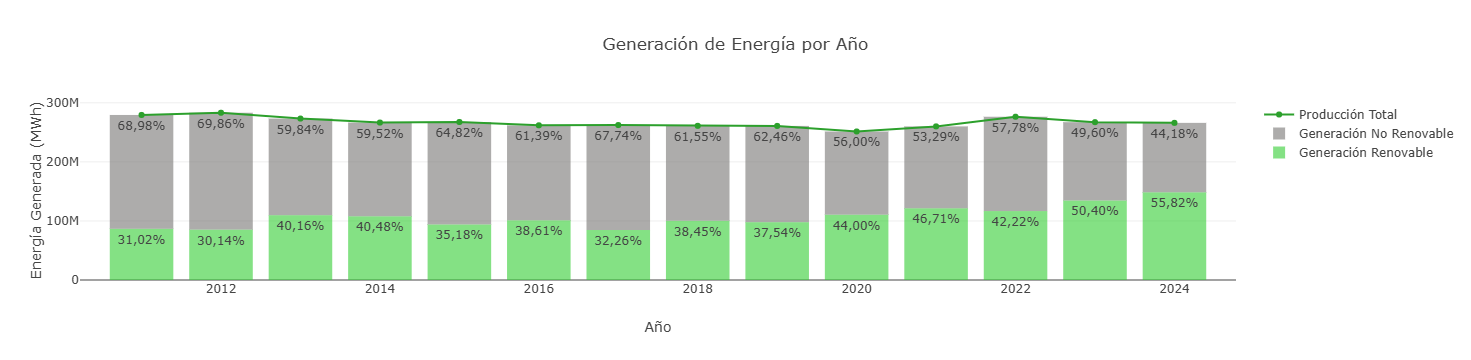

defined function analisisAnual

In [6]:
def analisisAnual(df: DataFrame): Unit = {

    val años = df.select("Año").distinct().orderBy("Año").as[String].collect.toSeq

    val renovables = df
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("ValorAnual")
        .as[Double]
        .collect
        .toSeq

    val noRenovables = df
        .filter($"Tipo" === "Generación no renovable")
        .orderBy("Año")
        .select("ValorAnual")
        .as[Double]
        .collect
        .toSeq

    val totalGenerado = df
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("TotalGenerado")
        .as[Double]
        .collect
        .toSeq
    
    val porcentajeRenovables = df
        .filter($"Tipo" === "Generación renovable")
        .orderBy("Año")
        .select("PorcentajeSobreTotal")
        .as[Double]
        .collect
        .toSeq
        .map(p => f"$p%.2f%%") 

    val porcentajeNoRenovables = df
        .filter($"Tipo" === "Generación no renovable")
        .orderBy("Año")
        .select("PorcentajeSobreTotal")
        .as[Double]
        .collect
        .toSeq
        .map(p => f"$p%.2f%%") 


    val traceRenovables = Bar(
        x = años,
        y = renovables,
        name = "Generación Renovable",
        marker = Marker(color = Color.RGBA(50, 205, 50, 0.6)),
        text = porcentajeRenovables,
        hoverinfo = HoverInfo.Text
    )

    val traceNoRenovables = Bar(
        x = años,
        y = noRenovables,
        name = "Generación No Renovable",
        marker = Marker(color = Color.RGBA(118, 116, 115, 0.6)),
        text = porcentajeNoRenovables,
        hoverinfo = HoverInfo.Text
    )

    val traceGeneracionTotal = Scatter(
            años, 
            totalGenerado, 
            name = "Producción Total"
    )

    val layout = Layout(
      title = "Generación de Energía por Año",
      barmode = BarMode.Stack,
      xaxis = Axis(title = "Año"),
      yaxis = Axis(title = "Energía Generada (MWh)")
    )

    val data = Seq(traceRenovables, traceNoRenovables, traceGeneracionTotal)
    plot(data, layout)
}
analisisAnual(datosConsulta1)

cmd10.sc:26: method apply in object Scatter is deprecated (since 0.8.0): Use Scatter() and chain-call .with* methods on it instead
val traceRenovables = Scatter(
                      ^
cmd10.sc:36: method apply in object Axis is deprecated (since 0.8.0): Use Axis() and chain-call .with* methods on it instead
  xaxis = Axis(title = "Año"),
          ^
cmd10.sc:37: method apply in object Axis is deprecated (since 0.8.0): Use Axis() and chain-call .with* methods on it instead
  yaxis = Axis(
          ^
cmd10.sc:34: method apply in object Layout is deprecated (since 0.8.0): Use Layout() and chain-call .with* methods on it instead
val layout = Layout(
             ^


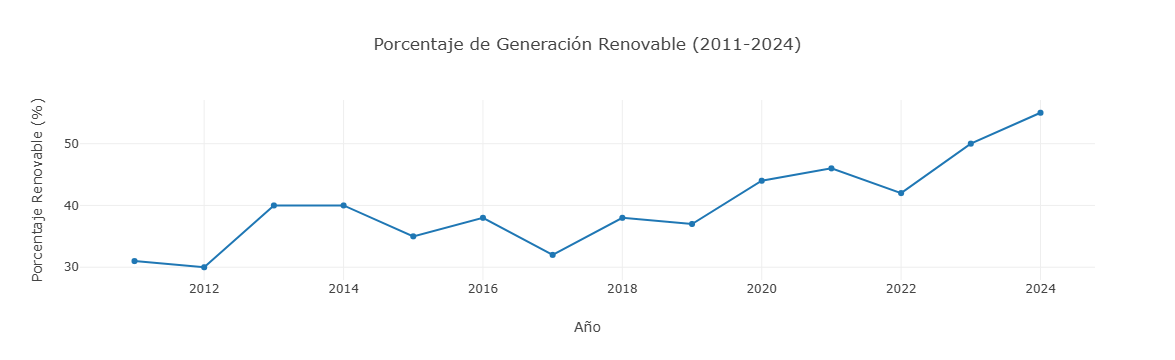

defined function graficaAnual

In [10]:
def graficaAnual: Unit = {
val porcentajeLimpiasAnual = datosConsulta1
    .filter($"Tipo" === "Generación renovable")
    .withColumn("PorcentajeRedondeado", round($"PorcentajeSobreTotal", 2).cast("Int"))
    .withColumn("AñoInt", year($"Año")) // Extraer el año como entero
    .select($"AñoInt",$"Tipo", $"TotalGenerado", $"Porcentajeredondeado")
    .orderBy($"AñoInt")


// Extraer la variable años
val años = porcentajeLimpiasAnual
   // Filtrar solo "Generación renovable"
  .select($"AñoInt") // Seleccionar la columna Año
  .as[Int] // Convertir directamente a Int
  .collect() // Recolectar los datos en el driver
  .toSeq // Convertir a Seq

// Extraer la variable renovables como Int
val renovables = porcentajeLimpiasAnual // Filtrar solo "Generación renovable"
  .select($"Porcentajeredondeado") // Seleccionar la columna Porcentajeredondeado
  .as[Int] // Forzar la conversión a Int
  .collect() // Recolectar los datos en el driver
  .toSeq // Convertir a Seq

// Crear el Scatter para la gráfica lineal
val traceRenovables = Scatter(
  años, 
  renovables, 
  //mode = ScatterMode(ScatterMode.Lines + ScatterMode.Markers), // Gráfica con líneas y puntos
  name = "Porcentaje Renovable"
)

// Configuración del Layout
val layout = Layout(
  title = "Porcentaje de Generación Renovable (2011-2024)",
  xaxis = Axis(title = "Año"),
  yaxis = Axis(
      title = "Porcentaje Renovable (%)"
  )
)

// Graficar
val data = Seq(traceRenovables)
plot(data,layout)
    
}
graficaAnual